In [148]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

In [149]:
class Raster:
    
    def __init__(self,raster:np.ndarray,noData:float=np.nan) -> None:
        self.rows,self.cols = raster.shape
        self.raster = raster.flatten()
        self.inds = np.arange(self.raster.shape[0])
        
        self.neighbor_Kernel = [-self.cols-1,-self.cols,-self.cols+1,-1,1,self.cols-1,self.cols,self.cols+1] 
        
    def get_Index(self,index:int) -> np.ndarray:
        # Return the 2d index given the 1d index
        return np.array([index//self.cols,index%self.cols]).astype(int)
    
    def get_Neighbors(self,index:int) -> list:
        """
        Return the 1d neighborhood indicies for the neighborhood of a given pixel and check bounds
        -------+-------+-----
        -cols-1| -cols | -cols+1
        -------+-------+-----
        -1     | 0     | +1
        -------+-------+-----
        cols-1 | cols  | cols+1
        -------+-------+-----
        + index
        """
        matcoords = np.array(self.get_Index(index)) # get 2d coords
        neighborhood = self.neighbor_Kernel + index
        
        # check if we are at the boundary
        if matcoords[0] <= 0: # If we are at the first row
            neighborhood[:3] = -999
            
        if matcoords[0] >= self.rows-1: # If we are at the last row
            neighborhood[-3:] = -999
            
        if matcoords[1] <= self.cols-1: # If we are at the first column
            remove = [0,3,5]
            neighborhood[remove] = -999
            
        if matcoords[1] >= self.cols-1: # If we are at the last column
            remove = [2,4,7]
            neighborhood[remove] = -999
        
        # remove out of bounds inds
        neighborhood = list(filter(lambda ind: ind != -999, neighborhood))
     
        # get 2d locs of neighborhood
        
        locs = [self.get_Index(x) for x in neighborhood]
      
        # get 2d distance to each point and stash that with index in the tuple
      
        distances = [np.linalg.norm((x-matcoords)) for x in locs]
        
        # join neighborhood indicies and their respective distances from the origin point
        
        
        
        neighbors_dists = list(zip([index]*len(neighborhood),neighborhood,distances))
        
        return neighbors_dists
    
    
        
    
        
        

In [150]:
elevs = np.load("/Users/franklyndunbar/Project/testarea.npy")
source_raster = np.zeros_like(elevs).astype(bool)
cost_raster = np.ones_like(elevs)
cost_raster *= np.inf
source_slice = np.s_[-1,:]
source_raster[source_slice] = True
cost_raster[source_slice] = 0

#elevs = np.ones_like(elevs)*1000

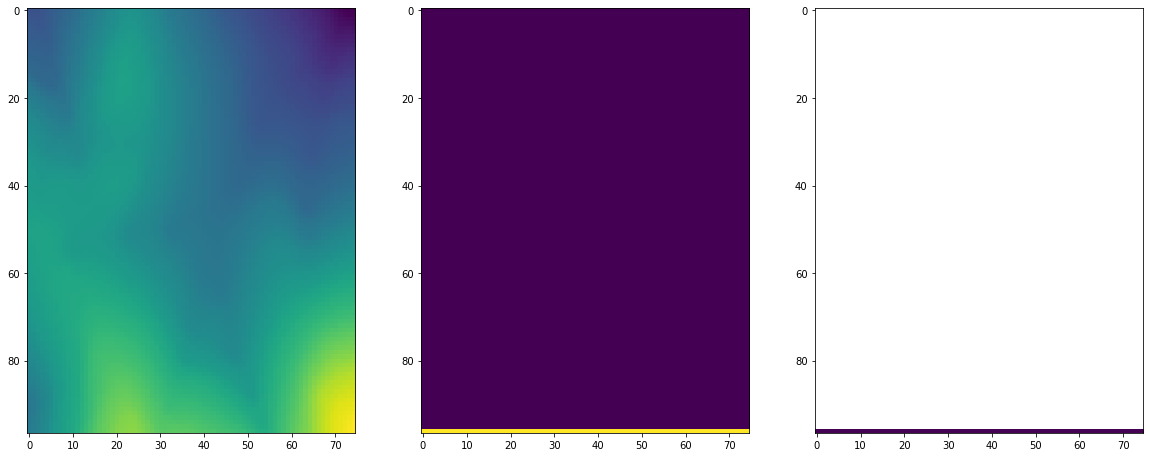

In [151]:
plt.subplot(1,3,1)
plt.imshow(elevs)
plt.subplot(1,3,2)
plt.imshow(source_raster)
plt.subplot(1,3,3)
plt.imshow(cost_raster)
plt.show()

In [152]:
print(cost_raster.shape)
elev_raster = Raster(elevs)
cost_raster = Raster(cost_raster)
source_raster = Raster(source_raster)

(97, 75)


In [153]:
def compute_costs(edge_set:list,elevs:np.ndarray,costs:np.ndarray) -> list:
    computed_costs = []
    for edges in edge_set:
        for edge in edges:
           
            start,stop,distance = edge
            dz = elevs[start] - elevs[stop]
            move_length = np.sqrt(distance**2 + dz**2)
            
            cost = costs[start] + move_length
            computed_costs.append((cost,stop))
    return computed_costs
        

In [154]:
# Init priority queue
PQ = []
heapq.heapify(PQ)

# Get source locations
source_locations = source_raster.inds[source_raster.raster]

# Get source elevations
source_elevs = elev_raster.raster[source_locations]

# Get source neighbors

source_neighbors = [source_raster.get_Neighbors(index) for index in source_locations]
print(source_neighbors[0])

[(7200, 7125, 1.0), (7200, 7126, 1.4142135623730951), (7200, 7201, 1.0)]


In [155]:
init_costs = compute_costs(source_neighbors,elev_raster.raster,cost_raster.raster)

In [156]:
for c in init_costs:
    heapq.heappush(PQ,c)


In [157]:
print(len(PQ))

223


In [158]:
iters = 0
while len(PQ) > 0:
 
    cost,loc = heapq.heappop(PQ)
    if cost > cost_raster.raster[loc]:
        continue
    else:
        cost_raster.raster[loc] = cost
        neighbors = [cost_raster.get_Neighbors(loc)]
      
        neighbor_costs = compute_costs(neighbors,elev_raster.raster,cost_raster.raster)
        for c in neighbor_costs:
            heapq.heappush(PQ,c)
       
        
        

In [159]:
test = cost_raster.raster

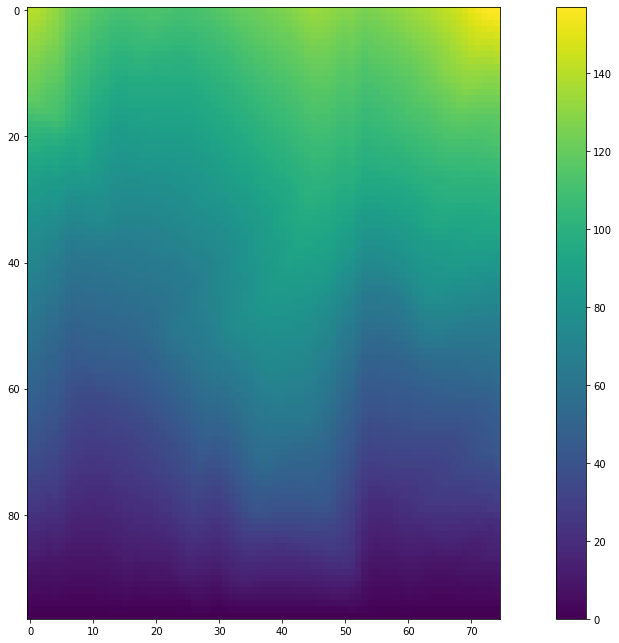

In [160]:
plt.rcParams["figure.figsize"] = (160/8,90/8)
costs = test.reshape(cost_raster.rows,cost_raster.cols)
plt.imshow(costs)
plt.plot()
plt.colorbar()
plt.show()

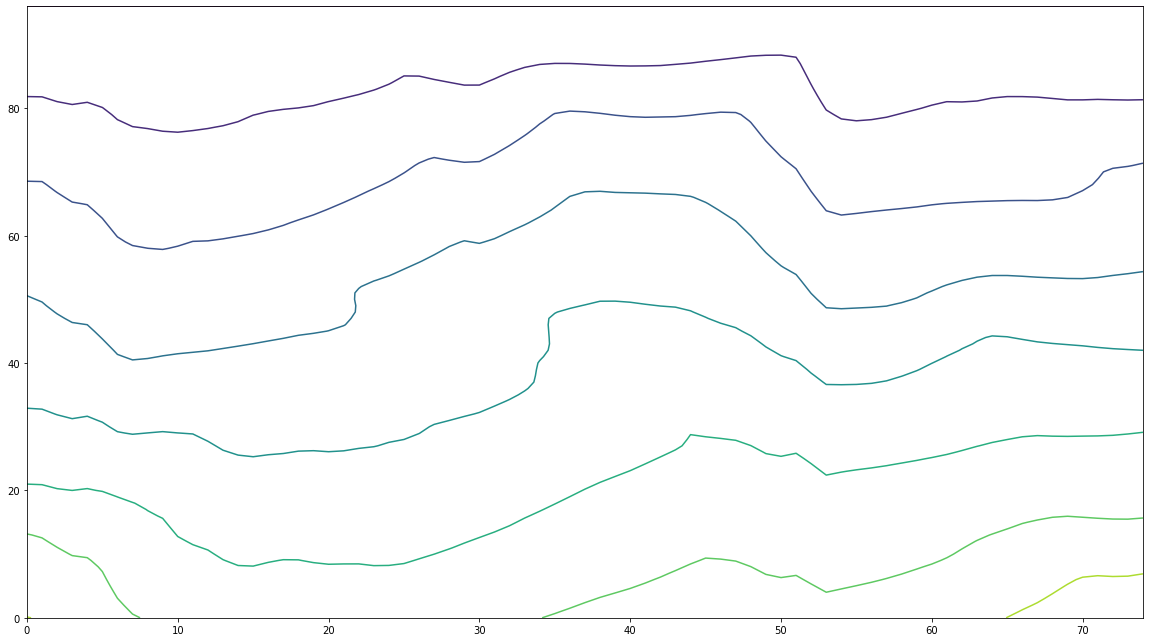

In [167]:
plt.contour(costs)
